# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer
import itertools  

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [6]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([[-10, 0, 10]]))
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([[1000, 0, 0]]))
assert np.isclose(probs[0, 0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [7]:
probs = linear_classifer.softmax(np.array([[-5, 0, 5], [-4, 0, 6]]))
linear_classifer.cross_entropy_loss(probs, [1, 2])

2.5046407076661206

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [8]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([[1, 0, 0]]), [[1]])
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, [[1]]), np.array([[1, 0, 0]], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [9]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(17)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# # Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [17]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [18]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [128]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.608786
Epoch 1, loss: 2.578784
Epoch 2, loss: 2.550954
Epoch 3, loss: 2.526245
Epoch 4, loss: 2.505394
Epoch 5, loss: 2.483122
Epoch 6, loss: 2.467298
Epoch 7, loss: 2.451356
Epoch 8, loss: 2.435842
Epoch 9, loss: 2.424889


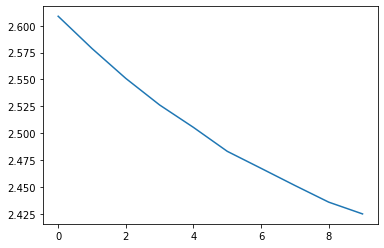

In [129]:
# let's look at the loss history!
plt.plot(loss_history)

In [130]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.115
Epoch 0, loss: 2.411435
Epoch 1, loss: 2.402383
Epoch 2, loss: 2.392385
Epoch 3, loss: 2.384350
Epoch 4, loss: 2.376266
Epoch 5, loss: 2.370571
Epoch 6, loss: 2.363494
Epoch 7, loss: 2.358460
Epoch 8, loss: 2.353469
Epoch 9, loss: 2.348225
Epoch 10, loss: 2.343689
Epoch 11, loss: 2.340393
Epoch 12, loss: 2.336975
Epoch 13, loss: 2.334680
Epoch 14, loss: 2.330778
Epoch 15, loss: 2.328536
Epoch 16, loss: 2.325855
Epoch 17, loss: 2.323803
Epoch 18, loss: 2.321549
Epoch 19, loss: 2.320268
Epoch 20, loss: 2.318411
Epoch 21, loss: 2.316635
Epoch 22, loss: 2.314989
Epoch 23, loss: 2.314042
Epoch 24, loss: 2.314574
Epoch 25, loss: 2.312237
Epoch 26, loss: 2.310462
Epoch 27, loss: 2.311160
Epoch 28, loss: 2.310537
Epoch 29, loss: 2.309730
Epoch 30, loss: 2.309156
Epoch 31, loss: 2.308272
Epoch 32, loss: 2.307523
Epoch 33, loss: 2.307544
Epoch 34, loss: 2.307470
Epoch 35, loss: 2.305915
Epoch 36, loss: 2.305841
Epoch 37, loss: 2.306043
Epoch 38, loss: 2.305413
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [212]:
num_epochs = 350
batch_size = 300
learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

# dict for saving accuracy results
accuracy_dict = dict()

# split array on train and test arrays
np.random.seed(17)
num_train = train_X.shape[0]
shuffled_indices = np.arange(num_train)
np.random.shuffle(shuffled_indices)
split = int(num_train*0.7)
train_indices = shuffled_indices[:split]
test_indices = shuffled_indices[split:]

for i in list(itertools.product(learning_rates, reg_strengths)):
    acc_list = list()
    # initialize Linear Classifier
    classifier = linear_classifer.LinearSoftmaxClassifier()
    classifier.fit(train_X[train_indices], train_y[train_indices], epochs=num_epochs, learning_rate=i[0], 
                   batch_size=batch_size, reg=i[1])
    # make a prediction
    pred = classifier.predict(train_X[test_indices])
    accuracy = multiclass_accuracy(pred, train_y[test_indices])
    accuracy_dict[i] = (accuracy, classifier)

sort_accuracy_dict = {k: v for k, v in sorted(accuracy_dict.items(), key=lambda item: item[1][0], reverse=True)}
best_accuracy = list(sort_accuracy_dict.values())[0][0]
best_classifier = list(sort_accuracy_dict.values())[0][1]

print(f'Best accuracy is {best_accuracy} for Linear Classifier with Learning Rate {best_learning_rate} and ' \
      f'Reg Strength {best_reg_strength}')   

Epoch 0, loss: 2.304183
Epoch 1, loss: 2.302271
Epoch 2, loss: 2.302436
Epoch 3, loss: 2.302558
Epoch 4, loss: 2.302484
Epoch 5, loss: 2.301739
Epoch 6, loss: 2.302759
Epoch 7, loss: 2.301724
Epoch 8, loss: 2.302420
Epoch 9, loss: 2.303226
Epoch 10, loss: 2.301546
Epoch 11, loss: 2.301844
Epoch 12, loss: 2.302825
Epoch 13, loss: 2.301024
Epoch 14, loss: 2.300590
Epoch 15, loss: 2.301954
Epoch 16, loss: 2.300839
Epoch 17, loss: 2.301073
Epoch 18, loss: 2.303006
Epoch 19, loss: 2.302228
Epoch 20, loss: 2.301842
Epoch 21, loss: 2.300845
Epoch 22, loss: 2.301458
Epoch 23, loss: 2.301472
Epoch 24, loss: 2.301259
Epoch 25, loss: 2.300893
Epoch 26, loss: 2.301708
Epoch 27, loss: 2.301744
Epoch 28, loss: 2.299288
Epoch 29, loss: 2.302162
Epoch 30, loss: 2.301664
Epoch 31, loss: 2.301639
Epoch 32, loss: 2.301528
Epoch 33, loss: 2.302741
Epoch 34, loss: 2.300535
Epoch 35, loss: 2.301246
Epoch 36, loss: 2.301235
Epoch 37, loss: 2.302232
Epoch 38, loss: 2.299834
Epoch 39, loss: 2.301980
Epoch 40, 

Epoch 41, loss: 2.297702
Epoch 42, loss: 2.301494
Epoch 43, loss: 2.302408
Epoch 44, loss: 2.301646
Epoch 45, loss: 2.300961
Epoch 46, loss: 2.299090
Epoch 47, loss: 2.299964
Epoch 48, loss: 2.301434
Epoch 49, loss: 2.300241
Epoch 50, loss: 2.301689
Epoch 51, loss: 2.301857
Epoch 52, loss: 2.301240
Epoch 53, loss: 2.301471
Epoch 54, loss: 2.300624
Epoch 55, loss: 2.299761
Epoch 56, loss: 2.300896
Epoch 57, loss: 2.301231
Epoch 58, loss: 2.300533
Epoch 59, loss: 2.301448
Epoch 60, loss: 2.301593
Epoch 61, loss: 2.300631
Epoch 62, loss: 2.299456
Epoch 63, loss: 2.299430
Epoch 64, loss: 2.299662
Epoch 65, loss: 2.299391
Epoch 66, loss: 2.299465
Epoch 67, loss: 2.300445
Epoch 68, loss: 2.299644
Epoch 69, loss: 2.299741
Epoch 70, loss: 2.300487
Epoch 71, loss: 2.299540
Epoch 72, loss: 2.299525
Epoch 73, loss: 2.299716
Epoch 74, loss: 2.300093
Epoch 75, loss: 2.299554
Epoch 76, loss: 2.299861
Epoch 77, loss: 2.300245
Epoch 78, loss: 2.298669
Epoch 79, loss: 2.299227
Epoch 80, loss: 2.300636


Epoch 78, loss: 2.298669
Epoch 79, loss: 2.299226
Epoch 80, loss: 2.300636
Epoch 81, loss: 2.299397
Epoch 82, loss: 2.298851
Epoch 83, loss: 2.298020
Epoch 84, loss: 2.300387
Epoch 85, loss: 2.298818
Epoch 86, loss: 2.299256
Epoch 87, loss: 2.299078
Epoch 88, loss: 2.298186
Epoch 89, loss: 2.299032
Epoch 90, loss: 2.298759
Epoch 91, loss: 2.298424
Epoch 92, loss: 2.300470
Epoch 93, loss: 2.298604
Epoch 94, loss: 2.297873
Epoch 95, loss: 2.299122
Epoch 96, loss: 2.299129
Epoch 97, loss: 2.298661
Epoch 98, loss: 2.298033
Epoch 99, loss: 2.297681
Epoch 100, loss: 2.298784
Epoch 101, loss: 2.298367
Epoch 102, loss: 2.298052
Epoch 103, loss: 2.298792
Epoch 104, loss: 2.297610
Epoch 105, loss: 2.297905
Epoch 106, loss: 2.296932
Epoch 107, loss: 2.297610
Epoch 108, loss: 2.296783
Epoch 109, loss: 2.298059
Epoch 110, loss: 2.298643
Epoch 111, loss: 2.296491
Epoch 112, loss: 2.298495
Epoch 113, loss: 2.298468
Epoch 114, loss: 2.298840
Epoch 115, loss: 2.298857
Epoch 116, loss: 2.298839
Epoch 11

Epoch 103, loss: 2.303234
Epoch 104, loss: 2.302031
Epoch 105, loss: 2.301533
Epoch 106, loss: 2.301999
Epoch 107, loss: 2.301510
Epoch 108, loss: 2.301599
Epoch 109, loss: 2.301820
Epoch 110, loss: 2.302059
Epoch 111, loss: 2.301609
Epoch 112, loss: 2.302297
Epoch 113, loss: 2.302430
Epoch 114, loss: 2.301386
Epoch 115, loss: 2.302298
Epoch 116, loss: 2.302734
Epoch 117, loss: 2.301538
Epoch 118, loss: 2.302359
Epoch 119, loss: 2.302616
Epoch 120, loss: 2.302482
Epoch 121, loss: 2.301276
Epoch 122, loss: 2.301261
Epoch 123, loss: 2.301974
Epoch 124, loss: 2.301881
Epoch 125, loss: 2.302801
Epoch 126, loss: 2.301701
Epoch 127, loss: 2.301994
Epoch 128, loss: 2.301747
Epoch 129, loss: 2.301705
Epoch 130, loss: 2.301873
Epoch 131, loss: 2.302815
Epoch 132, loss: 2.302004
Epoch 133, loss: 2.302730
Epoch 134, loss: 2.301992
Epoch 135, loss: 2.302302
Epoch 136, loss: 2.301528
Epoch 137, loss: 2.302239
Epoch 138, loss: 2.301375
Epoch 139, loss: 2.302044
Epoch 140, loss: 2.301035
Epoch 141, l

Epoch 131, loss: 2.302813
Epoch 132, loss: 2.302001
Epoch 133, loss: 2.302727
Epoch 134, loss: 2.301989
Epoch 135, loss: 2.302299
Epoch 136, loss: 2.301526
Epoch 137, loss: 2.302236
Epoch 138, loss: 2.301372
Epoch 139, loss: 2.302041
Epoch 140, loss: 2.301032
Epoch 141, loss: 2.301668
Epoch 142, loss: 2.302065
Epoch 143, loss: 2.301343
Epoch 144, loss: 2.301670
Epoch 145, loss: 2.301522
Epoch 146, loss: 2.301661
Epoch 147, loss: 2.302626
Epoch 148, loss: 2.301832
Epoch 149, loss: 2.302424
Epoch 150, loss: 2.301979
Epoch 151, loss: 2.301104
Epoch 152, loss: 2.301963
Epoch 153, loss: 2.302161
Epoch 154, loss: 2.301954
Epoch 155, loss: 2.301704
Epoch 156, loss: 2.302026
Epoch 157, loss: 2.302031
Epoch 158, loss: 2.301688
Epoch 159, loss: 2.301376
Epoch 160, loss: 2.302425
Epoch 161, loss: 2.302336
Epoch 162, loss: 2.302498
Epoch 163, loss: 2.302338
Epoch 164, loss: 2.301369
Epoch 165, loss: 2.301617
Epoch 166, loss: 2.302152
Epoch 167, loss: 2.301752
Epoch 168, loss: 2.301958
Epoch 169, l

Epoch 174, loss: 2.302268
Epoch 175, loss: 2.302188
Epoch 176, loss: 2.301598
Epoch 177, loss: 2.301866
Epoch 178, loss: 2.301889
Epoch 179, loss: 2.302455
Epoch 180, loss: 2.301735
Epoch 181, loss: 2.302197
Epoch 182, loss: 2.302063
Epoch 183, loss: 2.302040
Epoch 184, loss: 2.302103
Epoch 185, loss: 2.301723
Epoch 186, loss: 2.300726
Epoch 187, loss: 2.301694
Epoch 188, loss: 2.301551
Epoch 189, loss: 2.301804
Epoch 190, loss: 2.301708
Epoch 191, loss: 2.301342
Epoch 192, loss: 2.301420
Epoch 193, loss: 2.301840
Epoch 194, loss: 2.301903
Epoch 195, loss: 2.300602
Epoch 196, loss: 2.301958
Epoch 197, loss: 2.301551
Epoch 198, loss: 2.301600
Epoch 199, loss: 2.301986
Epoch 200, loss: 2.302212
Epoch 201, loss: 2.301636
Epoch 202, loss: 2.301470
Epoch 203, loss: 2.301347
Epoch 204, loss: 2.302023
Epoch 205, loss: 2.301595
Epoch 206, loss: 2.301569
Epoch 207, loss: 2.301493
Epoch 208, loss: 2.302135
Epoch 209, loss: 2.302293
Epoch 210, loss: 2.301557
Epoch 211, loss: 2.301849
Epoch 212, l

Epoch 197, loss: 2.302301
Epoch 198, loss: 2.302306
Epoch 199, loss: 2.302659
Epoch 200, loss: 2.302899
Epoch 201, loss: 2.301982
Epoch 202, loss: 2.302386
Epoch 203, loss: 2.301970
Epoch 204, loss: 2.302599
Epoch 205, loss: 2.302227
Epoch 206, loss: 2.302404
Epoch 207, loss: 2.301900
Epoch 208, loss: 2.302586
Epoch 209, loss: 2.303153
Epoch 210, loss: 2.302381
Epoch 211, loss: 2.302908
Epoch 212, loss: 2.302338
Epoch 213, loss: 2.302342
Epoch 214, loss: 2.302367
Epoch 215, loss: 2.302264
Epoch 216, loss: 2.302360
Epoch 217, loss: 2.302050
Epoch 218, loss: 2.302148
Epoch 219, loss: 2.303065
Epoch 220, loss: 2.302706
Epoch 221, loss: 2.302038
Epoch 222, loss: 2.301021
Epoch 223, loss: 2.302327
Epoch 224, loss: 2.302580
Epoch 225, loss: 2.302393
Epoch 226, loss: 2.301824
Epoch 227, loss: 2.301727
Epoch 228, loss: 2.301417
Epoch 229, loss: 2.301815
Epoch 230, loss: 2.302829
Epoch 231, loss: 2.301916
Epoch 232, loss: 2.302658
Epoch 233, loss: 2.302570
Epoch 234, loss: 2.302679
Epoch 235, l

Epoch 231, loss: 2.301913
Epoch 232, loss: 2.302656
Epoch 233, loss: 2.302568
Epoch 234, loss: 2.302676
Epoch 235, loss: 2.302444
Epoch 236, loss: 2.302613
Epoch 237, loss: 2.301859
Epoch 238, loss: 2.302620
Epoch 239, loss: 2.301629
Epoch 240, loss: 2.302472
Epoch 241, loss: 2.302936
Epoch 242, loss: 2.302366
Epoch 243, loss: 2.301483
Epoch 244, loss: 2.302500
Epoch 245, loss: 2.302540
Epoch 246, loss: 2.302341
Epoch 247, loss: 2.301199
Epoch 248, loss: 2.302081
Epoch 249, loss: 2.303142
Epoch 250, loss: 2.301816
Epoch 251, loss: 2.302803
Epoch 252, loss: 2.303751
Epoch 253, loss: 2.303270
Epoch 254, loss: 2.301749
Epoch 255, loss: 2.303493
Epoch 256, loss: 2.302157
Epoch 257, loss: 2.302560
Epoch 258, loss: 2.302911
Epoch 259, loss: 2.302442
Epoch 260, loss: 2.302986
Epoch 261, loss: 2.303246
Epoch 262, loss: 2.302902
Epoch 263, loss: 2.301815
Epoch 264, loss: 2.302460
Epoch 265, loss: 2.302184
Epoch 266, loss: 2.302001
Epoch 267, loss: 2.303385
Epoch 268, loss: 2.302774
Epoch 269, l

Epoch 276, loss: 2.303690
Epoch 277, loss: 2.302366
Epoch 278, loss: 2.302645
Epoch 279, loss: 2.301929
Epoch 280, loss: 2.302928
Epoch 281, loss: 2.302715
Epoch 282, loss: 2.302954
Epoch 283, loss: 2.301313
Epoch 284, loss: 2.302589
Epoch 285, loss: 2.301602
Epoch 286, loss: 2.301733
Epoch 287, loss: 2.301365
Epoch 288, loss: 2.301929
Epoch 289, loss: 2.302843
Epoch 290, loss: 2.302338
Epoch 291, loss: 2.302189
Epoch 292, loss: 2.302320
Epoch 293, loss: 2.302213
Epoch 294, loss: 2.301832
Epoch 295, loss: 2.302076
Epoch 296, loss: 2.302092
Epoch 297, loss: 2.302869
Epoch 298, loss: 2.302266
Epoch 299, loss: 2.302359
Best accuracy is 0.19407407407407407 for Linear Classifier with Learning Rate 0.001 and Reg Strength 0.0001


# Какой же точности мы добились на тестовых данных?

In [213]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print(f'Linear softmax classifier test set accuracy: {test_accuracy}')

Linear softmax classifier test set accuracy: 0.188
